In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

In [2]:
df = pd.read_csv('../../preprocessing/apartments_preprocessed.csv')

In [3]:
df.head()
df['price'].describe()

count     9922.000000
mean      1481.016831
std        948.711174
min        200.000000
25%        949.000000
50%       1270.000000
75%       1695.000000
max      25000.000000
Name: price, dtype: float64

In [4]:
from sklearn.model_selection import train_test_split

KNN je algoritam koji koristi mere bliskosti da bi klasifikovao instance. Ono sto ja zelim je da procenim cenu apartmana, ali tako sto cu objekte kategorisati:
1. Cheap/Affordable: [200, 1000)
2. Medium priced: [1000,1500)
3. Expensive: [1500,+)

In [5]:
binovi = [199, 1000, 1500, float('inf')]  # Definisanje granica binova
ime_kategorija = ['Cheap/Affordable', 'Medium priced', 'Expensive']

df['price_category'] = pd.cut(df['price'], bins=binovi, labels=ime_kategorija, right=True)


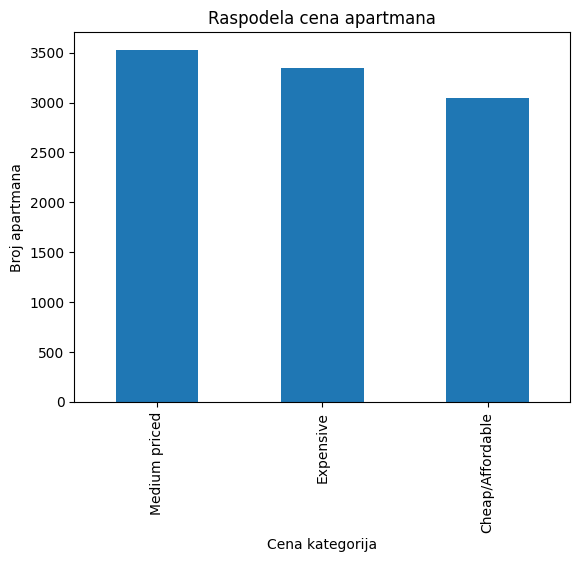

In [6]:
# Grupisanje po kategorijama i brojanje pojavljivanja
broj_pojavljivanja = df['price_category'].value_counts()

# Prikazivanje podataka na bar plot-u
broj_pojavljivanja.plot(kind='bar')
plt.xlabel('Cena kategorija')
plt.ylabel('Broj apartmana')
plt.title('Raspodela cena apartmana')
plt.show()

In [7]:
df['price_category'].value_counts()

price_category
Medium priced       3528
Expensive           3348
Cheap/Affordable    3046
Name: count, dtype: int64

In [8]:
df.isna().sum()

title             0
bathrooms         0
bedrooms          0
price             0
square_meters     0
cityname          0
state             0
latitude          0
longitude         0
source            0
luxury            0
price_category    0
dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

# Podela atributa
X = df[['square_meters','luxury','longitude','latitude']] # Features
y = df['price_category'] # Target: price

# Podela podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=41)

# Ispis informacija o veličini trening i test skupa
print("Veličina X_train:", X_train.shape)
print("Veličina X_test:", X_test.shape)
print("Veličina y_train:", y_train.shape)
print("Veličina y_test:", y_test.shape)

Veličina X_train: (7937, 4)
Veličina X_test: (1985, 4)
Veličina y_train: (7937,)
Veličina y_test: (1985,)


In [10]:
y_train

5091           Expensive
5856    Cheap/Affordable
7832           Expensive
3871       Medium priced
753            Expensive
              ...       
1199           Expensive
514            Expensive
2417       Medium priced
4326       Medium priced
6426           Expensive
Name: price_category, Length: 7937, dtype: category
Categories (3, object): ['Cheap/Affordable' < 'Medium priced' < 'Expensive']

Za atribute 'bathrooms', 'bedrooms', 'square_meters' potrebno je racunati euklidsku udaljenost, ali za udaljenost po preciznoj lokaciji nam je potrebna drugacija funkcija. Za racunanje rastojanja na Zemlji koristi se posebna haversine distanca (source: stackoverflow). Tako da za prva tri atributa udaljenost biti racunata uz pomoc euklidskog, a za poslednja dva uz pomoc haversine rastojanja

In [11]:
from math import radians, sin, cos, sqrt, atan2
def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # Prosečni poluprečnik Zemlje u kilometrima
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [12]:
def custom_distance(x, y):
    euc_distance = np.sqrt(np.sum((x[:2] - y[:2])**2))  # Euklidska udaljenost za prva četiri atributa
    haversine_dist = haversine_distance((x[2], x[3]), (y[2], y[3]))  # Haversine udaljenost za longitude i latitude
    total_distance = np.sqrt(euc_distance**2 + haversine_dist**2)
    return total_distance

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report
from termcolor import colored

def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred, zero_division=True))

In [15]:
knn = KNeighborsClassifier(metric=custom_distance)
knn.fit(X_train, y_train) # treninranje modela

KNeighborsClassifier(metric=<function custom_distance at 0x7f20893557e0>)

In [16]:
# Predicting results 
Y_pred = knn.predict(X_test)

# Evaluating the KNN model
report(knn, X_train, y_train)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.74      0.82      0.78      2437
       Expensive       0.82      0.81      0.81      2678
   Medium priced       0.73      0.67      0.70      2822

        accuracy                           0.76      7937
       macro avg       0.76      0.77      0.76      7937
    weighted avg       0.76      0.76      0.76      7937



In [17]:
report(knn, X_test, y_test, "test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.65      0.72      0.68       609
       Expensive       0.75      0.71      0.73       670
   Medium priced       0.61      0.59      0.60       706

        accuracy                           0.67      1985
       macro avg       0.67      0.67      0.67      1985
    weighted avg       0.67      0.67      0.67      1985



Izvestaj:  
Tacnost modela na trening skupu je 0.76, dok je na test skupu nesto manja, 0.67  
Model nije sjajan, solidan je, ali ima mali problem pri generalizaciji, sto zahteva eksperimentisanje sa parametrima.  

1. Preciznost <br>
Na treningu, 74% instanci koje su klasifikovane kao 'Cheap/Affordable' zaista pripadaju toj klasi, dok je na test skupu taj procenat za 9 manji. Slicno vazi i za klasu 'Expensive' - razlika je za 9 procenata. Model je najvise problema imao sa klasom 'Medium priced', koja оbuhvata najmanji raspon cena (500 dolara, za razliku od prve i trece klase koje imaju raspon, redom, 800 i 10000 (zbog luksuznih vila koje se nalaze u bazi).  
2. Odziv (Recall) <br>
Ova vrednost pokazuje da je na treningu, model predvideo 82% 'Cheap/Affordable' apartmana od ukupnog broja 'Cheap/Affordable' apartmana. Slicno vazi i za klase 'Medium priced' i 'Expencive', sa vrednostima 67% i 81%. Razlika u odnosu na test skup je ponovo oko 10 procenata, i ponovo se najlosije pokazao na kategoriji srednjih cena.  
3. F1-score <br>
F1-score je mera koja kombinuje preciznost (precision) i odziv (recall) modela i pruža informacije o ravnoteži između tačno pozitivnih i lažno pozitivnih predikcija, kao i tačno pozitivnih i lažno negativnih predikcija. U svim klasama je negde oko 70%, sto je zadovoljavajuc balans, ali ima prostora za napredak. 

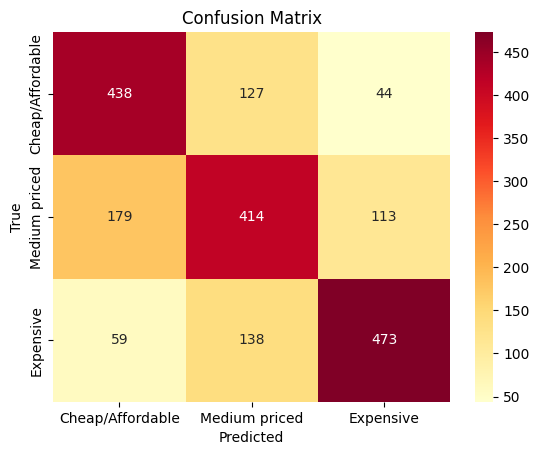

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, Y_pred, labels=ime_kategorija)

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=ime_kategorija, yticklabels=ime_kategorija)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Pozeljno je da vrednosti na dijagonali matrice konfuzije budu sto vece, odnosno na konkretnom primeru, da polja na dijagonali budu sto tamnija. Ova matrica je zadovoljavajuca. <br>
Interpretacija rezultata:

Cheap/Affordable:

    438 uzoraka su tacno predvidjeni kao Cheap/Affordable
    127 uzoraka su bili predvidjeni kao Medium priced, a zapravo su Cheap/Affordable
    44 uzoraka su bili predvidjeni kao Expensive, a zapravo su Cheap/Affordable

Medium priced:

    414 uzoraka su tacno predvidjeni kao Medium priced
    179 uzoraka su bili predvidjeni kao Cheap/Affordable, a zapravo su Medium priced
    113 uzoraka su bili predvidjeni kao Expensive, a zapravo su Medium priced

Expensive:

    473 uzoraka su tacno predvidjeni kao Expensive
    138 uzoraka su bili predvidjeni kao Medium priced, a zapravo su Expensive
    59 uzoraka su bili predvidjeni kao Cheap/Affordable, a zapravo su Expensive


# Optimizacija: GridSearchCV

In [19]:
# The grid search will also try different values of the maximum depth of the decision tree (2, 4, 6, 8)
params = {'criterion': ['gini', 'entropy'], 
          'max_depth': [2,4,6,8]
         }

params_grid = {'n_neighbors': range(5, 50, 5),
               'weights': ['uniform','distance'],
                'p': [1, 2]}

In [20]:
from sklearn.model_selection import GridSearchCV

estimator = GridSearchCV(KNeighborsClassifier(), params_grid, cv=4, verbose=4)
estimator.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4] END n_neighbors=5, p=1, weights=uniform;, score=0.669 total time=   0.1s
[CV 2/4] END n_neighbors=5, p=1, weights=uniform;, score=0.681 total time=   0.1s
[CV 3/4] END n_neighbors=5, p=1, weights=uniform;, score=0.666 total time=   0.1s
[CV 4/4] END n_neighbors=5, p=1, weights=uniform;, score=0.676 total time=   0.2s
[CV 1/4] END n_neighbors=5, p=1, weights=distance;, score=0.693 total time=   0.0s
[CV 2/4] END n_neighbors=5, p=1, weights=distance;, score=0.705 total time=   0.0s
[CV 3/4] END n_neighbors=5, p=1, weights=distance;, score=0.685 total time=   0.0s
[CV 4/4] END n_neighbors=5, p=1, weights=distance;, score=0.691 total time=   0.0s
[CV 1/4] END n_neighbors=5, p=2, weights=uniform;, score=0.669 total time=   0.2s
[CV 2/4] END n_neighbors=5, p=2, weights=uniform;, score=0.674 total time=   0.1s
[CV 3/4] END n_neighbors=5, p=2, weights=uniform;, score=0.674 total time=   0.1s
[CV 4/4] END n_neighbors=5, p=2,

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 50, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [21]:
y_pred = estimator.predict(X_test)

In [22]:
# Let's see what the best parameters are based on the estimator:

estimator.best_params_


{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

In [23]:

estimator.best_score_

0.6986244489924434

In [24]:
report(estimator.best_estimator_, X_train, y_train)

Classification report for model KNeighborsClassifier on training data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.97      0.99      0.98      2437
       Expensive       0.98      0.99      0.99      2678
   Medium priced       0.99      0.96      0.98      2822

        accuracy                           0.98      7937
       macro avg       0.98      0.98      0.98      7937
    weighted avg       0.98      0.98      0.98      7937



In [25]:
report(estimator.best_estimator_, X_test, y_test, "test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.74      0.73      0.73       609
       Expensive       0.78      0.79      0.78       670
   Medium priced       0.63      0.63      0.63       706

        accuracy                           0.71      1985
       macro avg       0.71      0.71      0.71      1985
    weighted avg       0.71      0.71      0.71      1985



Tacnost na trening skupu je 99%, a na test skupu samo 71%. To govori o tome da se model preprilagodio. Ova situacija se mozda moze resiti podelom podataka na trening, test, i dodatan validacioni skup. Ovo je skup podataka koji se koristi za procenu performansi modela tokom procesa podešavanja parametara.

In [26]:
from sklearn.model_selection import train_test_split

# Podela skupa podataka na trening i test skup
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Podela trening skupa na trening i validacioni skup
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=41)


In [27]:
from sklearn.model_selection import GridSearchCV

estimator = GridSearchCV(KNeighborsClassifier(), params_grid, cv=4, verbose=4)
estimator.fit(X_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits
[CV 1/4] END n_neighbors=5, p=1, weights=uniform;, score=0.649 total time=   0.1s
[CV 2/4] END n_neighbors=5, p=1, weights=uniform;, score=0.641 total time=   0.1s
[CV 3/4] END n_neighbors=5, p=1, weights=uniform;, score=0.637 total time=   0.1s
[CV 4/4] END n_neighbors=5, p=1, weights=uniform;, score=0.641 total time=   0.1s
[CV 1/4] END n_neighbors=5, p=1, weights=distance;, score=0.669 total time=   0.0s
[CV 2/4] END n_neighbors=5, p=1, weights=distance;, score=0.658 total time=   0.0s
[CV 3/4] END n_neighbors=5, p=1, weights=distance;, score=0.645 total time=   0.0s
[CV 4/4] END n_neighbors=5, p=1, weights=distance;, score=0.643 total time=   0.0s
[CV 1/4] END n_neighbors=5, p=2, weights=uniform;, score=0.629 total time=   0.1s
[CV 2/4] END n_neighbors=5, p=2, weights=uniform;, score=0.628 total time=   0.1s
[CV 3/4] END n_neighbors=5, p=2, weights=uniform;, score=0.624 total time=   0.1s
[CV 4/4] END n_neighbors=5, p=2,

GridSearchCV(cv=4, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 50, 5), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [28]:
best_model = estimator.best_estimator_
report(best_model, X_val, y_val, "validation")

Classification report for model KNeighborsClassifier on validation data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.76      0.68      0.72       507
       Expensive       0.73      0.76      0.74       543
   Medium priced       0.57      0.60      0.58       538

        accuracy                           0.68      1588
       macro avg       0.69      0.68      0.68      1588
    weighted avg       0.68      0.68      0.68      1588



In [29]:
report(best_model, X_test, y_test, "test")

Classification report for model KNeighborsClassifier on test data
---------------------------------------------------------------------------------
                  precision    recall  f1-score   support

Cheap/Affordable       0.74      0.68      0.71       614
       Expensive       0.73      0.78      0.75       663
   Medium priced       0.60      0.60      0.60       708

        accuracy                           0.69      1985
       macro avg       0.69      0.69      0.69      1985
    weighted avg       0.69      0.69      0.68      1985



Ovaj model se nije prilagodio, ali takodje daje losije rezultate u odnosu na malopre.

U svakom slucaju, tacnost modela na test skupu ni u jednom trenutku nije presla 80%. 

In [33]:
import pickle

with open('data.pkl', 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

In [34]:
df.to_csv('apartments_classes.csv', index=False)